### Imports

In [44]:
import pandas as pd
import numpy as np
import json
import pickle

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

import matplotlib.pyplot as plt
import seaborn as sns

### Load data

In [3]:
data = pd.read_csv("../../../Project Files/data/class_01/bikes.csv")
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Create outcome variable
Based on this outcome variable we choose R-squared as evaluaiton metric. For now we are only interested in overall model fit.

In [4]:
data["casual_prop"] = data["casual"] / data["cnt"]

### Transformations

In [5]:
# make dummy variables from selected variables
columns = ["season", "mnth", "weekday", "weathersit"]
data = pd.get_dummies(data, columns=columns, prefix=columns, dtype=int)

In [6]:
data

,instant,dteday,yr,hr,holiday,workingday,temp,atemp,hum,windspeed,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,1,2011-01-01,0,0,0,0,0.24,0.2879,0.81,0.0000,...,0,0,0,0,0,1,1,0,0,0
1,2,2011-01-01,0,1,0,0,0.22,0.2727,0.80,0.0000,...,0,0,0,0,0,1,1,0,0,0
2,3,2011-01-01,0,2,0,0,0.22,0.2727,0.80,0.0000,...,0,0,0,0,0,1,1,0,0,0
3,4,2011-01-01,0,3,0,0,0.24,0.2879,0.75,0.0000,...,0,0,0,0,0,1,1,0,0,0
4,5,2011-01-01,0,4,0,0,0.24,0.2879,0.75,0.0000,...,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,19,0,1,0.26,0.2576,0.60,0.1642,...,1,0,0,0,0,0,0,1,0,0
17375,17376,2012-12-31,1,20,0,1,0.26,0.2576,0.60,0.1642,...,1,0,0,0,0,0,0,1,0,0
17376,17377,2012-12-31,1,21,0,1,0.26,0.2576,0.60,0.1642,...,1,0,0,0,0,0,1,0,0,0
17377,17378,2012-12-31,1,22,0,1,0.26,0.2727,0.56,0.1343,...,1,0,0,0,0,0,1,0,0,0


### Train-val-test split

In [7]:
# the number of rows corresponding to 15%
n_15 = int(0.15 * len(data))

# isolate test set
data_test = data.iloc[-n_15:,:]

# isolate train and val
data_train_val = data.iloc[:-n_15,:]

# isolate val
data_val = data_train_val.iloc[-n_15:,:]

# isolate train from train and val
data_train = data_train_val.iloc[:-n_15,:]

del data, data_train_val


### X y split

In [47]:
drop = ['dteday', 'casual', 'registered', 'cnt', 'casual_prop']
X_train = data_train.drop(drop, axis=1)
y_train = data_train["casual_prop"].to_numpy()
X_val = data_val.drop(drop, axis=1)
y_val = data_val["casual_prop"].to_numpy()
X_test = data_test.drop(drop, axis=1)
y_test = data_test["casual_prop"].to_numpy()

# save data
with open('data/train.pkl', 'wb') as file:
    pickle.dump([X_train, y_train], file)

with open('data/val.pkl', 'wb') as file:
    pickle.dump([X_val, y_val], file)

with open('data/test.pkl', 'wb') as file:
    pickle.dump([X_test, y_test], file)


### Dummy model

In [32]:
performances = []

mean_value = y_train.mean()
model_name = 'dummy'

for y, nsplit in zip([y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    performance = np.sqrt(mean_squared_error(y, [mean_value]*y.shape[0]))
    r2 = r2_score(y, [mean_value]*y.shape[0])
    performances.append({'model': model_name,
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

performances

[{'model': 'dummy', 'split': 'train', 'rmse': 0.1426, 'r2': 0.0},
 {'model': 'dummy', 'split': 'val', 'rmse': 0.1224, 'r2': -0.0753},
 {'model': 'dummy', 'split': 'test', 'rmse': 0.12, 'r2': -0.0734}]

### Instant as only predictor

In [33]:
X_train_instant = X_train["instant"].to_numpy().reshape(-1,1)
X_val_instant = X_val["instant"].to_numpy().reshape(-1,1)
X_test_instant = X_test["instant"].to_numpy().reshape(-1,1)

instant_reg = LinearRegression()
instant_reg.fit(X_train_instant, y_train)

LinearRegression()

In [34]:
for x,y,nsplit in zip([X_train_instant, X_val_instant, X_test_instant],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    preds = instant_reg.predict(x)
    r2 = r2_score(y, preds)
    performance = np.sqrt(mean_squared_error(y, preds))
    performances.append({'model': 'instant_mdl',
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

performances

[{'model': 'dummy', 'split': 'train', 'rmse': 0.1426, 'r2': 0.0},
 {'model': 'dummy', 'split': 'val', 'rmse': 0.1224, 'r2': -0.0753},
 {'model': 'dummy', 'split': 'test', 'rmse': 0.12, 'r2': -0.0734},
 {'model': 'instant_mdl', 'split': 'train', 'rmse': 0.1425, 'r2': 0.0023},
 {'model': 'instant_mdl', 'split': 'val', 'rmse': 0.127, 'r2': -0.1575},
 {'model': 'instant_mdl', 'split': 'test', 'rmse': 0.1161, 'r2': -0.0053}]

### KNN regression and linear regression with weather and temporal predictors


In [35]:
# prepare X
drop = ['instant', 'holiday', 'workingday', 'temp']
weath_temp_columns = [i for i in X_train.columns if i not in drop]

X_train_weath_temp = X_train[weath_temp_columns].to_numpy()
X_val_weath_temp = X_val[weath_temp_columns].to_numpy()
X_test_weath_temp = X_test[weath_temp_columns].to_numpy()

# fitting models
weath_temp_reg = LinearRegression()
weath_temp_reg.fit(X_train_weath_temp, y_train)

weath_temp_knn = KNeighborsRegressor(n_neighbors=5)
weath_temp_knn.fit(X_train_weath_temp, y_train)

# evaluate linear reg
for x,y,nsplit in zip([X_train_weath_temp, X_val_weath_temp, X_test_weath_temp],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    preds = weath_temp_reg.predict(x)
    r2 = r2_score(y, preds)
    performance = np.sqrt(mean_squared_error(y, preds))
    performances.append({'model': 'weath_temp_linear_mdl',
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

# evaluate knn reg
for x,y,nsplit in zip([X_train_weath_temp, X_val_weath_temp, X_test_weath_temp],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    preds = weath_temp_knn.predict(x)
    r2 = r2_score(y, preds)
    performance = np.sqrt(mean_squared_error(y, preds))
    performances.append({'model': 'weath_temp_knn_mdl',
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})
performances



[{'model': 'dummy', 'split': 'train', 'rmse': 0.1426, 'r2': 0.0},
 {'model': 'dummy', 'split': 'val', 'rmse': 0.1224, 'r2': -0.0753},
 {'model': 'dummy', 'split': 'test', 'rmse': 0.12, 'r2': -0.0734},
 {'model': 'instant_mdl', 'split': 'train', 'rmse': 0.1425, 'r2': 0.0023},
 {'model': 'instant_mdl', 'split': 'val', 'rmse': 0.127, 'r2': -0.1575},
 {'model': 'instant_mdl', 'split': 'test', 'rmse': 0.1161, 'r2': -0.0053},
 {'model': 'weath_temp_linear_mdl',
  'split': 'train',
  'rmse': 0.1141,
  'r2': 0.3595},
 {'model': 'weath_temp_linear_mdl',
  'split': 'val',
  'rmse': 0.0997,
  'r2': 0.2868},
 {'model': 'weath_temp_linear_mdl',
  'split': 'test',
  'rmse': 0.1036,
  'r2': 0.1993},
 {'model': 'weath_temp_knn_mdl',
  'split': 'train',
  'rmse': 0.0855,
  'r2': 0.6404},
 {'model': 'weath_temp_knn_mdl', 'split': 'val', 'rmse': 0.099, 'r2': 0.2956},
 {'model': 'weath_temp_knn_mdl', 'split': 'test', 'rmse': 0.099, 'r2': 0.27}]

### 'Kitchen sink' model (all predictors)

In [36]:
# prepare X
X_train_sink = X_train.to_numpy()
X_val_sink = X_val.to_numpy()
X_test_sink = X_test.to_numpy()

# fitting models
sink_reg = LinearRegression()
sink_reg.fit(X_train_sink, y_train)

sink_knn = KNeighborsRegressor(n_neighbors=5)
sink_knn.fit(X_train_sink, y_train)

# evaluate linear reg
for x,y,nsplit in zip([X_train_sink, X_val_sink, X_test_sink],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    preds = sink_reg.predict(x)
    r2 = r2_score(y, preds)
    performance = np.sqrt(mean_squared_error(y, preds))
    performances.append({'model': 'sink_linear_mdl',
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

# evaluate knn reg
for x,y,nsplit in zip([X_train_sink, X_val_sink, X_test_sink],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    preds = sink_knn.predict(x)
    r2 = r2_score(y, preds)
    performance = np.sqrt(mean_squared_error(y, preds))
    performances.append({'model': 'sink_knn_mdl',
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})
performances

[{'model': 'dummy', 'split': 'train', 'rmse': 0.1426, 'r2': 0.0},
 {'model': 'dummy', 'split': 'val', 'rmse': 0.1224, 'r2': -0.0753},
 {'model': 'dummy', 'split': 'test', 'rmse': 0.12, 'r2': -0.0734},
 {'model': 'instant_mdl', 'split': 'train', 'rmse': 0.1425, 'r2': 0.0023},
 {'model': 'instant_mdl', 'split': 'val', 'rmse': 0.127, 'r2': -0.1575},
 {'model': 'instant_mdl', 'split': 'test', 'rmse': 0.1161, 'r2': -0.0053},
 {'model': 'weath_temp_linear_mdl',
  'split': 'train',
  'rmse': 0.1141,
  'r2': 0.3595},
 {'model': 'weath_temp_linear_mdl',
  'split': 'val',
  'rmse': 0.0997,
  'r2': 0.2868},
 {'model': 'weath_temp_linear_mdl',
  'split': 'test',
  'rmse': 0.1036,
  'r2': 0.1993},
 {'model': 'weath_temp_knn_mdl',
  'split': 'train',
  'rmse': 0.0855,
  'r2': 0.6404},
 {'model': 'weath_temp_knn_mdl', 'split': 'val', 'rmse': 0.099, 'r2': 0.2956},
 {'model': 'weath_temp_knn_mdl', 'split': 'test', 'rmse': 0.099, 'r2': 0.27},
 {'model': 'sink_linear_mdl', 'split': 'train', 'rmse': 0.113

### Save performances

In [39]:
file_path = 'performances.txt'
with open(file_path, 'w') as file:
    json.dump(performances, file)

### Visualise performances

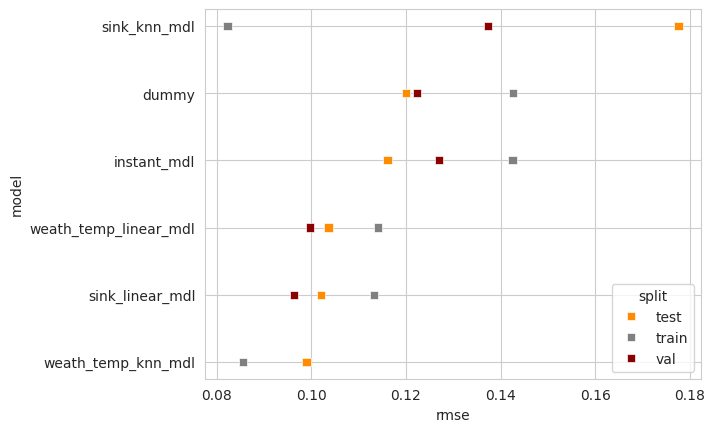

In [43]:
perf_df = pd.DataFrame(performances)
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

### Save maximal model
That is, the one with lowest out-of-sample rmse

In [45]:
with open('models/sink_linear.pkl', 'wb') as file:
    pickle.dump(sink_reg, file)